## Официальный github репозиторий с библиотекой LightAutoML находится [тут](https://github.com/sberbank-ai-lab/LightAutoML)

# Шаг 0.0. Установка LightAutoML

Данный шаг требуется, если работа ведется не со скачанным из github репозитория кодом, а, например, в Google Colab/Kaggle kernels или вы хотите установить LightAutoML на свою машину: 

In [1]:
!pip install -U pip
!pip install -U lightautoml

# Шаг 0.1. Импорт нужных библиотек

Здесь мы импортируем все то, что будем использовать в процессе работы:
- Стандартные библиотеки питона для логгинга, закачки данных и т.п.
- Стандартные DS библиотеки типа numpy, pandas и scikit-learn, a также torch (в следующей ячейке поймем зачем)
- Модули нашего LightAutoML, такие как пресеты, таск и декоратор отчетов

In [2]:
# Стандартные питоновские библиотеки
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Дополнительное полезное
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Импорт пресетов, таска и профайлера
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

[2021-06-14 22:34:12,505] (WARNING): /usr/local/lib/python3.6/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)



# Шаг 0.2. Используемые константы

Заранее зададим некоторые параметры-константы, которые будем использовать в процессе решения:
- `N_THREADS` - количество виртуальных ядер ЦПУ, которые выделяются для решения задачи
- `RANDOM_STATE` - случайный сид для воспроизводимости
- `TEST_SIZE` - доля данных, которую отложим в houldout
- `TIMEOUT` - лимит по времени работы (в секундах), который выделяется на решение задачи
- `TARGET_NAME` - название колонки с целевой переменной

In [3]:
N_THREADS = 8 
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 1200 # 20 minutes
TARGET_NAME = 'target'

# Шаг 0.3. Предварительный сетап используемых библиотек

Для большей гарантии воспроизводимости зафиксируем случайный сид из numpy, а также установим максимальное количество потоков для Torch (который очень любит раскатываться на все доступные потоки сервера):

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Шаг 0.4. Загрузка данных 

Загрузим файл с данными, которые будем в дальнейшем использовать:

In [5]:
%%time

data = pd.read_csv('example_data/jobs_train.csv')
data.head()

CPU times: user 92.3 ms, sys: 9.03 ms, total: 101 ms
Wall time: 35.9 ms


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21.0,NaN,NaN,1.0,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,99.0,Pvt Ltd,5.0,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,0.0,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,0.0,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21.0,99.0,Funded Startup,4.0,8,0.0


# Шаг 0.5. Разделим данные на трейн и тест 

Поскольку у нас есть только один файл с данными, то для дополнительной проверки качества модели выделим из него 20% в качестве holdout:

In [6]:
%%time

train_data, test_data = train_test_split(data, 
                                         test_size=TEST_SIZE, 
                                         stratify=data[TARGET_NAME], 
                                         random_state=RANDOM_STATE)
logging.info('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

[2021-06-14 22:34:14,372] (INFO): Data splitted. Parts sizes: train_data = (15326, 14), test_data = (3832, 14)


CPU times: user 8.04 ms, sys: 4.02 ms, total: 12.1 ms
Wall time: 11.3 ms


In [7]:
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
17855,6135,city_21,0.624,NaN,Has relevent experience,no_enrollment,Graduate,STEM,10.0,99.0,Pvt Ltd,1.0,90,0.0
17664,6455,city_103,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,5.0,NaN,NaN,0.0,15,0.0
13404,5856,city_50,0.896,Male,Has relevent experience,no_enrollment,Graduate,STEM,12.0,4999.0,NGO,5.0,36,0.0
13366,27191,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5.0,500.0,Funded Startup,1.0,53,0.0
15670,16751,city_67,0.855,Female,Has relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,1.0,158,1.0


# =============== Построение LightAutoML модели ===============


# Шаг 1. Создадим Task

В ячейке ниже мы создадим объект типа Task - класса, позволяющего сообщить LightAutoML тип решаемой задачи, а также при необходимости подходящие лосс и метрику качества (более подробно об их задании можно прочитать по [ссылке](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) в нашей документации):

In [8]:
%%time

task = Task('binary', )

CPU times: user 3.38 ms, sys: 0 ns, total: 3.38 ms
Wall time: 3.11 ms


# Шаг 2. Установим роли для признаков

Для того, чтобы LightAutoML стало понятно, что именно делать с данными, **обязательно** нужно задать какая именно колонка является целевой. Информацию об остальных колонках можно указывать, но это не является обязательным - в LightAutoML встроен автоматический типизатор колонок.

In [9]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['enrollee_id']
         }

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs


# Шаг 3. Создадим модель LightAutoML - TabularAutoML пресет

В ячейке ниже для создания LightAutoML модели воспользуемся классом `TabularAutoML` - пресетом, позволяющим строить пайплайны типа:

![TabularAutoML preset pipeline](imgs/tutorial_blackbox_pipeline.png)

всего за несколько строк кода. Разберем подробнее передаваемые при инициализации параметры:
- `task` - тип решаемой задачи (единственный **обязательный** параметр)
- `timeout` - время в секундах, выделяемое на решение задачи
- `cpu_limit` - количество виртуальных ядер ЦПУ, выделяемых для решения задачи
- `reader_params` - изменение параметров работы объекта Reader внутри пресета, отвечающего за первоначальную работу с данными, определение их типов, создание корректного кросс-валидационного разбиения и т.п. В нашем случае мы как раз выставим ему `N_THREADS` потоков для определения типов признаков и `RANDOM_STATE` в качестве сида кросс-валидации

**Важное замечание**: ключ `reader_params` является одним из ключей YAML конфига, который используются внутри `TabularAutoML` пресета. [Более подробно](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) его структуру с детальными комментариями можно посмотреть в документации LightAutoML. Каждый ключ из приведенных в этом конфиге может быть изменен пользователем при необходимости на этапе инициализации пресета.

Дополнительно, чтобы на выходе работы с моделью получить автоматический отчет по ней, обернем наш объект типа `TabularAutoML` в декоратор отчета `ReportDeco` и далее будем использовать обернутую версию.

In [ ]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'random_state': RANDOM_STATE},
                       #general_params={'use_algos': [['linear_l2', 'lgb']]}
                      )

RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl)

oof_pred = automl_rd.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

# Шаг 4. Важности признаков в полученной модели 

Для подсчета важности признаков в LightAutoML реализованы 2 метода:
- Быстрый (`fast`) - использует важности признаков с модели-селектора признаков LightGBM. Работает очень быстро, фактически всегда (кроме кейсов, когда отборщик был принудительно отключен), не требует дополнительных выборок с таргетом
- Точный (`accurate`) - считает permutation importance каждого признака для всей модели на переданной выборке. Работает всегда, но может это делать довольно долго (сильно зависит от самой финальной модели, объема дополнительной выборки и т.п.)

Поскольку посчитать важности признаков мы хотим именно при помощи модели, то в данном случае используем `automl_rd.model` вместо `automl_rd`, но **будьте внимательны** - все, что было посчитано через `automl_rd.model` не попадает в отчет.

CPU times: user 40.9 ms, sys: 47 µs, total: 41 ms
Wall time: 39.9 ms


<AxesSubplot:xlabel='Feature'>

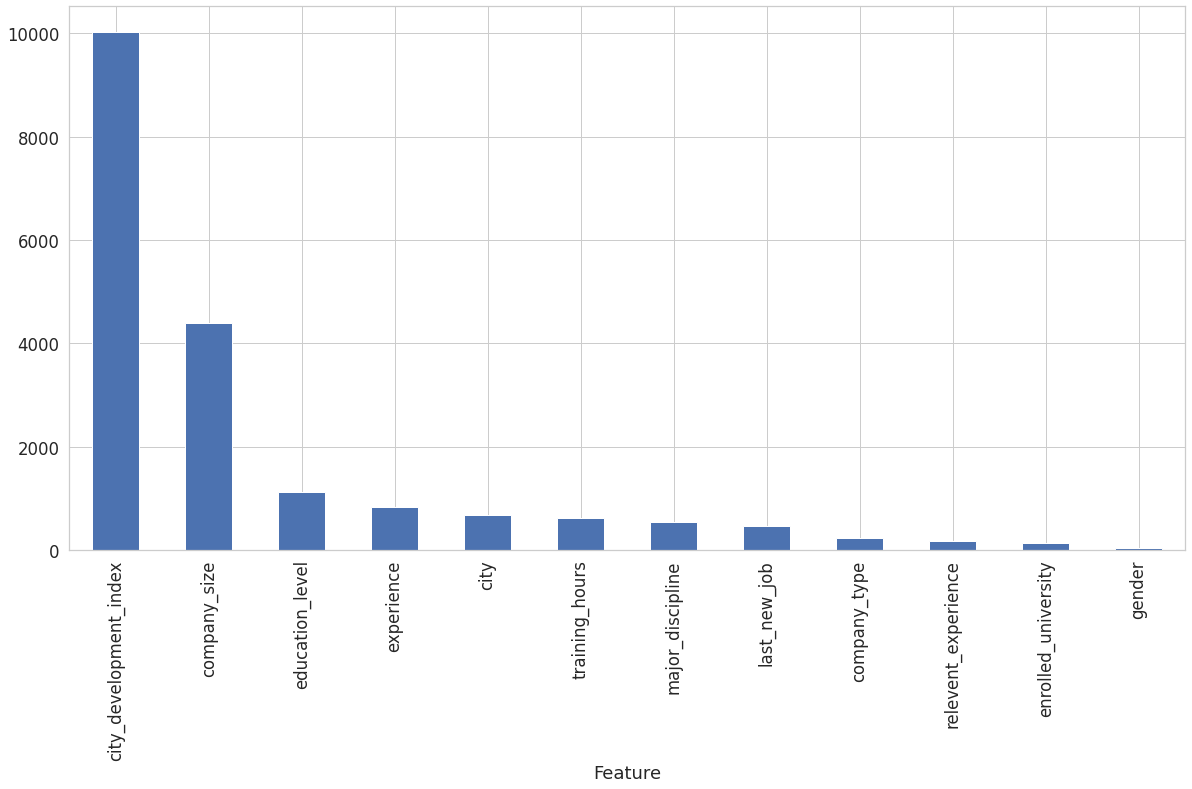

In [11]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

LightAutoML used 12 feats
1/12 Calculated score for city: 0.0035084
2/12 Calculated score for company_type: 0.0312360
3/12 Calculated score for company_size: 0.0305093
4/12 Calculated score for city_development_index: 0.1189825
5/12 Calculated score for gender: -0.0000031
6/12 Calculated score for major_discipline: 0.0028529
7/12 Calculated score for last_new_job: 0.0035317
8/12 Calculated score for education_level: 0.0011390
9/12 Calculated score for enrolled_university: 0.0013325
10/12 Calculated score for relevent_experience: 0.0024722
11/12 Calculated score for training_hours: -0.0011920
12/12 Calculated score for experience: 0.0036997
CPU times: user 15.4 s, sys: 2.06 s, total: 17.5 s
Wall time: 6.56 s


<AxesSubplot:xlabel='Feature'>

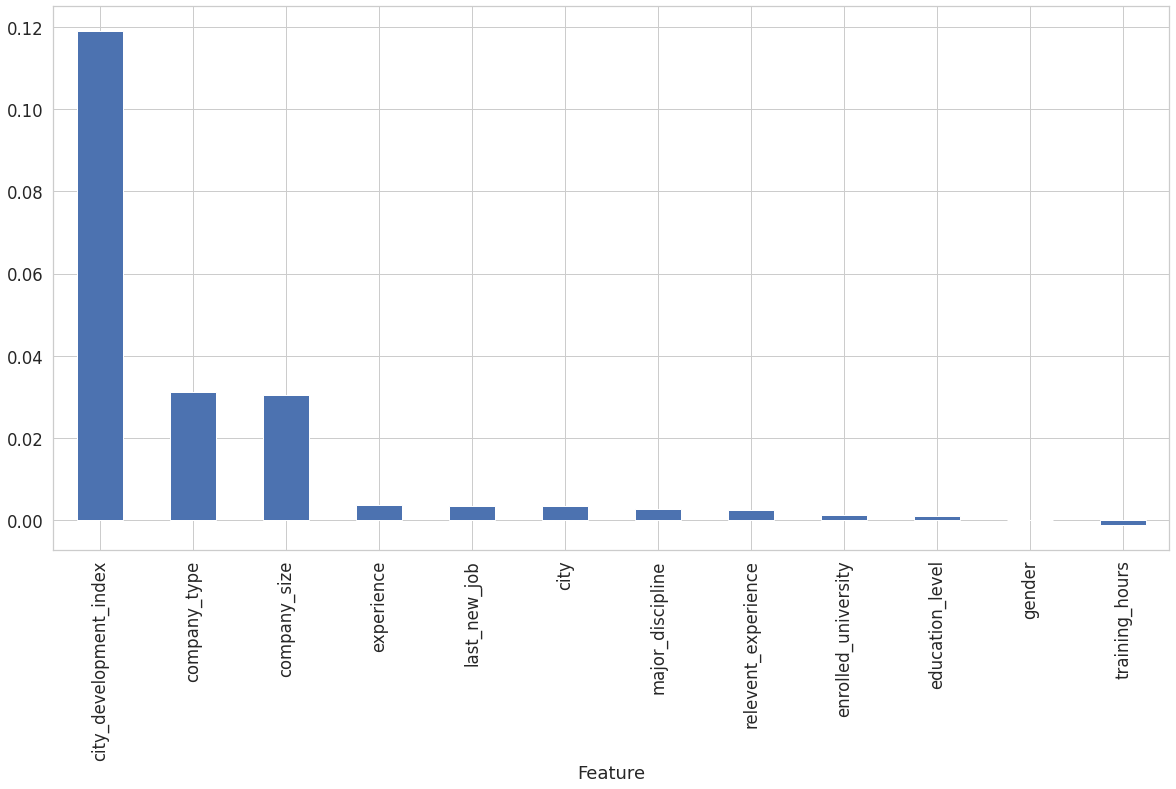

In [12]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', test_data, silent = False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

# Шаг 5. Выполним предсказание на holdout и посмотрим на метрику качества

In [13]:
%%time

test_pred = automl_rd.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

[2021-06-14 22:44:48,296] (INFO): Prediction for test data:
array([[0.04313495],
       [0.62670255],
       [0.07484004],
       ...,
       [0.20521131],
       [0.06609596],
       [0.0654742 ]], dtype=float32)
Shape = (3832, 1)


CPU times: user 2.46 s, sys: 233 ms, total: 2.69 s
Wall time: 1.86 s


In [14]:
logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-06-14 22:44:48,302] (INFO): Check scores...
[2021-06-14 22:44:48,308] (INFO): OOF score: 0.8057498508925341
[2021-06-14 22:44:48,311] (INFO): TEST score: 0.8160833255991279


# Шаг 6. Построение отчета о модели TabularAutoML

Поскольку мы использовали `automl_rd`, то есть обернутый в декоратор отчета пресет, то отчет собирался постепенно в процессе работы с моделью и уже доступен в указанной нами для декоратора папке `tabularAutoML_model_report` под стандартным именем `lama_interactive_report.html` (или можно кликнуть по [ссылке](tabularAutoML_model_report/lama_interactive_report.html)).

Несколько примеров из сгенерированного отчета:

![TabularAutoML auto report example 1](imgs/tutorial_blackbox_report_1.png)

![TabularAutoML auto report example 2](imgs/tutorial_blackbox_report_2.png)

![TabularAutoML auto report example 3](imgs/tutorial_blackbox_report_3.png)

# Шаг 7. Потратим максимум из timeout - TabularUtilizedAutoML пресет

Как мы видели, на шаге 3 модель, основанная на TabulaAutoML пресете, закончила свое обучение за ~10 минут, хотя мы задавали 20 минут таймаута. 

Давайте еще больше расширим этот таймаут до 40 минут и предложим LightAutoML потратить его на создание зачастую более стабильной и качественной модели - будем использовать для этого `TabularUtilizedAutoML` пресет. Он обладает абсолютно таким же API, как и `TabularAutoML`, поэтому с точки зрения написания нового кода для запуска это будет быстро:

In [ ]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = 2 * TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

# Шаг 8. Подсчет важности признаков для новой модели 

CPU times: user 40.6 ms, sys: 7.91 ms, total: 48.5 ms
Wall time: 46.1 ms


<AxesSubplot:xlabel='Feature'>

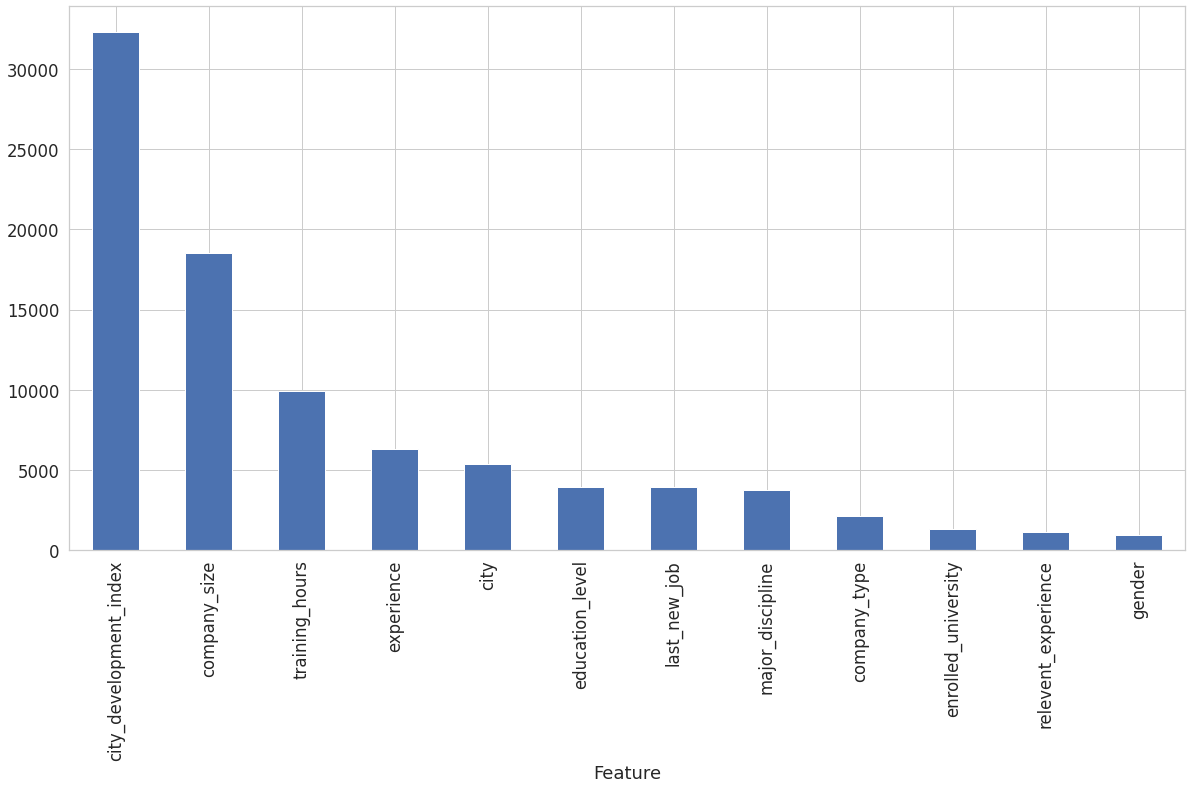

In [16]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast', silent = False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

# Шаг 9. Снова выполним предсказание на holdout и посмотрим на метрику качества

In [17]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

[2021-06-14 23:19:30,413] (INFO): Prediction for test data:
array([[0.04762448],
       [0.6185899 ],
       [0.06567395],
       ...,
       [0.19834751],
       [0.06344185],
       [0.05933513]], dtype=float32)
Shape = (3832, 1)


CPU times: user 3.23 s, sys: 291 ms, total: 3.52 s
Wall time: 1.3 s


In [18]:
logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-06-14 23:19:30,420] (INFO): Check scores...
[2021-06-14 23:19:30,426] (INFO): OOF score: 0.8097495517678559
[2021-06-14 23:19:30,429] (INFO): TEST score: 0.8188190505307487


Таким образом, при помощи `TabularUtilizedAutoML` нам удалось получить качество лучше чем у `TabularAutoML` пресета как с точки зрения OOF скора, так и результата на отложенной тестовой выборке.

# Дополнительные материалы 

- [Github репозиторий LightAutoML](https://github.com/sberbank-ai-lab/LightAutoML)
- [Документация](https://lightautoml.readthedocs.io/en/latest)